In [1]:
from hetmech.matrix import *
from hetmech.degree_weight import *

In [2]:
import json
import urllib.request
import numpy as np
from scipy import sparse
import hetio.readwrite
import hetio.hetnet
import pandas as pd
import time
import random
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

## Load the graph and metaedges

In [3]:
%%time
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetio.readwrite.read_graph(url)
metagraph = graph.metagraph

CPU times: user 1min 19s, sys: 1.37 s, total: 1min 21s
Wall time: 1min 23s


# Load Metapaths

In [14]:
def get_specific_paths(startnode, endnode, minlen, maxlen):
    """Returns a list of metapaths from a start- to an end-node with shortest and 
    longest lengths specified"""
    paths = list()
    working_paths = list()
    for length in range(minlen, maxlen+1):
        working_paths = get_all_paths(length)
        paths += [i for i in working_paths 
                  if re.findall('^[A-Z]{1,2}', i)[0] == startnode 
                  and re.findall('[A-Z]{1,2}$', i)[0] == endnode]
    return paths

In [18]:
## Load metapaths

def load_metapaths():
    """Load 1206 Rephetio metapaths"""
    with urllib.request.urlopen(
        'https://github.com/dhimmel/learn/raw/25093893ed53730ab5cfdac49561c4b6bd3376c5/all-features/data/metapaths.json'
    ) as data_file:
        metapaths = json.loads(data_file.read().decode())
    assert len(metapaths) == 1206
    abbrevs = [metapath['abbreviation'] for metapath in metapaths] # extract str from list(dicts)
    return abbrevs

def filter_compatible(metapaths):
    """Returns a list of paths within the input list which currently work
    with hetmech's DWPC implementation"""
    incompatible_metapaths = []
    for metapath in metapaths:
        try:
            get_segments(graph.metagraph, metagraph.metapath_from_abbrev(metapath))
        except ValueError:
            incompatible_metapaths.append(metapath)
    compatible_metapaths = sorted(list(set(metapaths) - set(incompatible_metapaths)))
    print("First path -- {}\n{} are compatible\n{} not compatible".format(
        compatible_metapaths[0], len(compatible_metapaths), len(metapaths)-len(compatible_metapaths)))
    return compatible_metapaths

compatible_metapaths = filter_compatible(load_metapaths())

First path -- CbG<rG<rGaD
752 are compatible
454 not compatible


In [16]:
def get_node_edge_dict():
    """Return a dictionary with keys=start_metanodes and values=list of
    corresponding metaedge/end_metanode combinations"""
    metaedges = list(set([
        'DuG', 'G<rG', 'CpD', 'GpMF', 'GpBP', 'AuG', 'DdG', 
        'SEcC', 'BPpG', 'CrC', 'CcSE', 'MFpG', 'AdG', 'GdA', 
        'DpS', 'SpD', 'DrD', 'PCiC', 'CbG', 'GbC', 'GuD', 'GcG', 
        'GuC', 'CtD', 'GuA', 'CiPC', 'PWpG', 'GdC', 'GpPW', 
        'Gr>G', 'AlD', 'GiG', 'GaD', 'AeG', 'CCpG', 'CuG', 'CdG', 
        'DaG', 'DtC', 'DpC', 'DlA', 'GdD', 'GeA', 'GpCC']
    ))
    metanodes = sorted(list(set(
        [re.match('^[A-Z]{1,2}', i)[0] for i in metaedges]
    )))
    node_to_edge = dict()
    for node in metanodes:
        node_to_edge[node] = []
        for edge in metaedges:
            if re.match('^[A-Z]{1,2}', edge)[0] == node:
                node_to_edge[node] = \
                    node_to_edge[node] + re.findall('(?<=[A-Z]{1,2})[/>/<a-z]{1,2}[A-Z]{1,2}', edge)
    return node_to_edge

def build_paths(start, maxlen):
    """Return all metapaths of length maxlen starting with start metanode"""
    node_to_edge = get_node_edge_dict()
    paths = [start]
    def step(lst):
        newpaths = list()
        for base in lst:
            endnode = re.findall('[A-Z]{1,2}$', base)[0] # Re expression to find the endnode
            for next_node in node_to_edge[endnode]:
                if len(re.findall('[A-Z]{1,2}', base+next_node)) <= maxlen: # next path is not too long
                    newpaths += [base+next_node] 
                else:
                    return lst
        return step(newpaths)
    return step(paths)

build_paths('G', 4)[:10]

def get_all_paths(maxlen):
    """Returns all potential metapaths of a certain length.
    Setting maxlen=2 return a list of metaedges"""
    node_to_edge = get_node_edge_dict()
    metapaths = list()
    for node in node_to_edge.keys():
        metapaths += build_paths(node, maxlen)
    return metapaths

get_all_paths(4)[:10]

# Create a function to find all paths between two metanodes with len in a range

def get_specific_paths(startnode, endnode, minlen, maxlen):
    """Returns a list of metapaths from a start- to an end-node with shortest and 
    longest lengths specified"""
    paths = list()
    working_paths = list()
    for length in range(minlen, maxlen+1):
        working_paths = get_all_paths(length)
        paths += [i for i in working_paths 
                  if re.findall('^[A-Z]{1,2}', i)[0] == startnode 
                  and re.findall('[A-Z]{1,2}$', i)[0] == endnode]
    return paths

First path -- CbG<rG<rGaD
752 are compatible
454 not compatible


## See what the breakdown of Rephetio metapaths looks like.

How many are BAAB, etc.
1. No node repeats
2. Any number of nodes repeated once, but disjoint: AXABYBCZC
3. two nodes repeated once, nested: BAAB
4. two nodes repeated once, interleaved: BABA
5. any other situation

In [485]:
all_metapaths = load_metapaths()

In [566]:
all_metapaths[:6]

['CbGaD', 'CbGdD', 'CbGuD', 'CdGaD', 'CdGdD', 'CdGuD']

In [559]:
def remove_unnecessary(string):
    """Removes all characters not integral to the characterization of
    a given metapath. Edges are automatically removed.
    
    Examples:
    ---------
    'AxByBzC' -> ['BB']
    'AABBCC' -> ['AA', 'BB', 'CC']
    'ABBA' -> ['ABBA']
    'BABA' -> ['BABA']
    'ABCDEFA' -> ['AA']
    """
    nodes = re.split('[a-z<>]{1,2}', string)
    node_repeats = [v for i, v in enumerate(nodes) if v in nodes[i+1:]]
    ordered_repeats = [node for node in nodes if node in node_repeats]
    return ordered_repeats


In [395]:
disjoint = "AxAxBxB"
no_repeats = "AxBxCxD"
common = "AxBxCxB"
baab = "AxBxBxA"
baba = "AxBxAxB"
triple = "AxAxBxBxDxCxCxA"
multi = "AxAxBxBxDxD"
type_list = [disjoint, no_repeats, common, baab, baba, triple, multi]

In [560]:
def reformat(string):
    """Returns a list of repeated nodes grouped
    
    Example outputs:
    ----------------
    ['AA', 'BB', 'CC']
    ['ABBA'], ['ABAB'], ['']

    """
    chars_list = remove_unnecessary(string)
    
    # actual functionality to test if the element is part of a repeat    
    repeats_list = [''.join(list(v)) for i, v in itertools.groupby(chars_list)]            
    if len(chars_list) - len(repeats_list) <= 1:
        repeats_list = [''.join(repeats_list)]
    
    
    return repeats_list    

In [561]:
def characterize(string):
    """Takes a metapath string and returns a string categorization
    
    Outputs:
    --------
    no_repeats
        eg. 'ABCD'
    disjoint
        eg. 'ABACDC'
    abba
        eg. 'BAAB'
    abab
        eg. 'BABA'
    Other
        eg. 'ABCABC', 'ABBCCA', 'ABCCBA', etc.
    """
    try:
        formatted = reformat(string)
    except NotImplementedError:
        return "Other"
    if not formatted[0]:
        category = "no_repeats"
    elif len(formatted) == 1:
        if len(formatted[0]) < 4:
            category = 'disjoint'
        elif formatted[0][0] == formatted[0][-1]:
            category = 'abba'
        else:
            category = 'abab'
    else:
        if all([i==len(i)*i[0] and len(i) != 1 for i in formatted]):
            category = 'disjoint'
        else:
            category = 'Other'
    return category

In [562]:
for i in type_list:
    print(i, reformat(i), characterize(i))

AxAxBxB ['AA', 'BB'] disjoint
AxBxCxD [''] no_repeats
AxBxCxB ['BB'] disjoint
AxBxBxA ['ABBA'] abba
AxBxAxB ['ABAB'] abab
AxAxBxBxDxCxCxA ['AA', 'BB', 'CC', 'A'] Other
AxAxBxBxDxD ['AA', 'BB', 'DD'] disjoint


In [563]:
categories = pd.DataFrame([[v,characterize(v)] for v in all_metapaths], columns=['metapath', 'type'])
categories.head()

,metapath,type
0,CbGaD,no_repeats
1,CbGdD,no_repeats
2,CbGuD,no_repeats
3,CdGaD,no_repeats
4,CdGdD,no_repeats


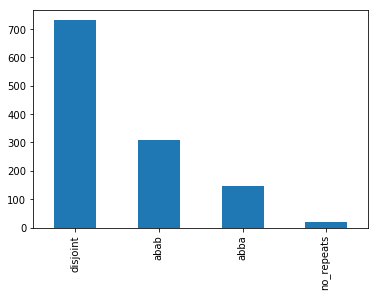

In [564]:
categories.type.value_counts().plot(kind='bar')

In [573]:
categories.loc[categories['type'] == 'disjoint'].head()

,metapath,type
6,CpDrD,disjoint
7,CrCpD,disjoint
8,CrCtD,disjoint
9,CtDrD,disjoint
13,CbG<rGaD,disjoint
